# Warsaw AI - experiments on MNIST with ensembles

In this notebook we will explore potential advances from model ensembing in case of uncertainty estimation. Let's start from loading data:

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 14s 1us/step


Now - let's apply a simple data normalization:

In [2]:
x_train = x_train.reshape((-1, 28 * 28)) / 255.0
x_test = x_test.reshape((-1, 28 * 28)) / 255.0

Now - let's prepare a function which will build a simple model for MNIST:

In [3]:
from keras.layers import Dense, Input
from keras.models import Model

def build_simple_model(
    layers=2,
    units=256,
):
    input_ = Input(shape=(28 * 28,))
    
    aux_layer = input_
    
    for _ in range(layers):
        aux_layer = Dense(
            units=units, 
            activation='relu')(aux_layer)
        
    output = Dense(10, activation='softmax')(aux_layer)
    
    model = Model(input_, output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_simple_model()

and:
- prepare functions which will fit a list of models on data,
- make predictions on list of models.

In [4]:
def fit_models(models, *args, **kwargs):
    """Fit a list of models and return the list of training histories."""
    return [model.fit(*args, **kwargs) for model in models]

def models_predict(models, *args, **kwargs):
    """Predict using list of models."""
    return [model.predict(*args, **kwargs) for model in models]

Now let's fit a set of models on data:

In [6]:
MODEL_NB = 10

EPOCHS = 10
SHUFFLE = False
VAL_SPLIT = 0.1
 
models = [build_simple_model() for _ in range(MODEL_NB)]

histories = fit_models(
    models=models,
    x=x_train,
    y=y_train,
    shuffle=SHUFFLE,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 9s 166us/step - loss: 0.2178 - acc: 0.9351 - val_loss: 0.1060 - val_acc: 0.9662
Epoch 2/10
54000/54000 [==============================] - 8s 157us/step - loss: 0.0918 - acc: 0.9717 - val_loss: 0.0914 - val_acc: 0.9737
Epoch 3/10
54000/54000 [==============================] - 8s 157us/step - loss: 0.0587 - acc: 0.9820 - val_loss: 0.0915 - val_acc: 0.9727
Epoch 4/10
54000/54000 [==============================] - 9s 160us/step - loss: 0.0444 - acc: 0.9857 - val_loss: 0.0873 - val_acc: 0.9755
Epoch 5/10
54000/54000 [==============================] - 9s 159us/step - loss: 0.0361 - acc: 0.9883 - val_loss: 0.0872 - val_acc: 0.9757
Epoch 6/10
54000/54000 [==============================] - 9s 158us/step - loss: 0.0278 - acc: 0.9910 - val_loss: 0.0876 - val_acc: 0.9783
Epoch 7/10
54000/54000 [==============================] - 9s 172us/step - loss: 0.0219 - acc: 0.9926 - val_loss: 0.1021 - v

54000/54000 [==============================] - 10s 183us/step - loss: 0.0223 - acc: 0.9927 - val_loss: 0.0908 - val_acc: 0.9780
Epoch 9/10
54000/54000 [==============================] - 9s 171us/step - loss: 0.0170 - acc: 0.9941 - val_loss: 0.0985 - val_acc: 0.9783
Epoch 10/10
54000/54000 [==============================] - 9s 162us/step - loss: 0.0181 - acc: 0.9942 - val_loss: 0.1120 - val_acc: 0.9755
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 9s 163us/step - loss: 0.2224 - acc: 0.9337 - val_loss: 0.1014 - val_acc: 0.9693
Epoch 2/10
54000/54000 [==============================] - 8s 155us/step - loss: 0.0902 - acc: 0.9724 - val_loss: 0.0869 - val_acc: 0.9728
Epoch 3/10
54000/54000 [==============================] - 10s 187us/step - loss: 0.0578 - acc: 0.9816 - val_loss: 0.0918 - val_acc: 0.9740
Epoch 4/10
54000/54000 [==============================] - 10s 179us/step - loss: 0.0413 - acc: 0.9863 - val_loss: 0.0869 - val_acc:

Now, let's have a look at model training histories:

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)

for model_nb, history in enumerate(histories):
    plt.plot(history.history['loss'], label='Model %d' % model_nb)
    plt.title('Loss of models')
    plt.legend()
    
plt.subplot(2, 2, 2)

for model_nb, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label='Model %d' % model_nb)
    plt.title('Validation Loss of models')
    plt.legend()
    
plt.subplot(2, 2, 3)

for model_nb, history in enumerate(histories):
    plt.plot(history.history['acc'], label='Model %d' % model_nb)
    plt.title('Accuracy of models')
    plt.legend()

plt.subplot(2, 2, 4)

for model_nb, history in enumerate(histories):
    plt.plot(history.history['val_acc'], label='Model %d' % model_nb)
    plt.title('Validation accuracy of models')
    plt.legend()
    
plt.show()

<Figure size 1000x1000 with 4 Axes>

Now - let's compute _entropy of mean_ and _mean entropy_:

In [8]:
import numpy as np


predictions = models_predict(models, x=x_test)
predictions_array = np.array(predictions)

EPS = 1e-16

def compute_entropy(results):
    results = np.clip(results, EPS, 1 - EPS)
    return -(results * np.log(results)).sum(axis=-1)

entropy_of_mean = compute_entropy(predictions_array.mean(axis=0))
mean_of_entropies = np.array([compute_entropy(prediction) for prediction in predictions]).mean(axis=0)

Now - let's have a look at their distribution:

Text(0,0.5,'Mean of entropies')

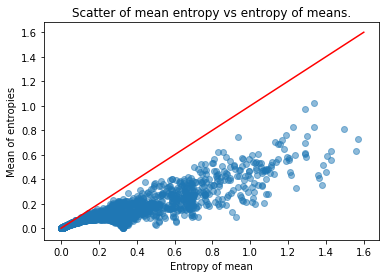

In [9]:
plt.scatter(entropy_of_mean, mean_of_entropies, alpha=0.5)
plt.plot([0, 1.6], [0, 1.6], c='r')
plt.title('Scatter of mean entropy vs entropy of means.')
plt.xlabel('Entropy of mean')
plt.ylabel('Mean of entropies')

Now - let's analyze the connection between mean entropy, entropy of mean and missclassification:

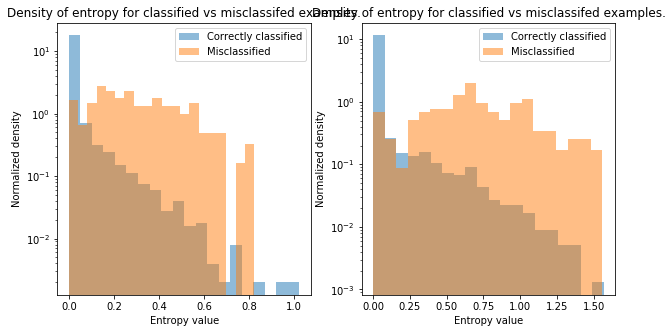

In [10]:
predictions = predictions_array.mean(axis=0).argmax(axis=-1)
correctly_classified = predictions == y_test

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.hist(
    x=mean_of_entropies[correctly_classified], 
    density=True,
    bins=20,
    alpha=0.5, 
    log=True,
    label='Correctly classified',
)
_ = plt.hist(
    x=mean_of_entropies[np.logical_not(correctly_classified)],
    density=True,
    bins=20, 
    alpha=0.5, 
    log=True,
    label='Misclassified',
)

plt.title('Density of entropy for classified vs misclassifed examples.')
plt.xlabel('Entropy value')
plt.ylabel('Normalized density')
_ = plt.legend()

plt.subplot(1, 2, 2)

plt.hist(
    x=entropy_of_mean[correctly_classified], 
    density=True,
    bins=20,
    alpha=0.5, 
    log=True,
    label='Correctly classified',
)
_ = plt.hist(
    x=entropy_of_mean[np.logical_not(correctly_classified)],
    density=True,
    bins=20, 
    alpha=0.5, 
    log=True,
    label='Misclassified',
)

plt.title('Density of entropy for classified vs misclassifed examples.')
plt.xlabel('Entropy value')
plt.ylabel('Normalized density')
_ = plt.legend()

Now let's analyze this merics w.r.t. their misclassification predictive power:

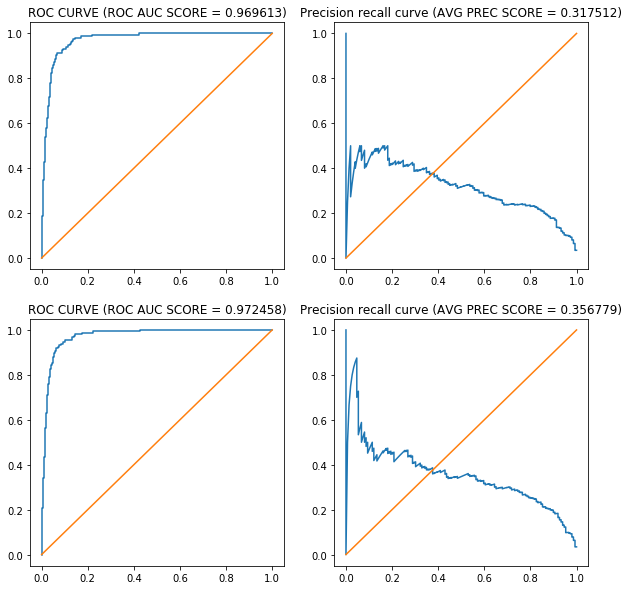

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)

tpr, fpr, thresholds = roc_curve(1 - correctly_classified, mean_of_entropies)
plt.plot(tpr, fpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC CURVE (ROC AUC SCORE = %f)' % roc_auc_score(1 - correctly_classified, mean_of_entropies))

plt.subplot(2, 2, 2)

prec, rec, thresholds = precision_recall_curve(1 - correctly_classified, mean_of_entropies)
plt.plot(rec, prec)
plt.plot([0, 1], [0, 1])
_ = plt.title('Precision recall curve (AVG PREC SCORE = %f)' % average_precision_score(1 - correctly_classified, mean_of_entropies))

plt.subplot(2, 2, 3)

tpr, fpr, thresholds = roc_curve(1 - correctly_classified, entropy_of_mean)
plt.plot(tpr, fpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC CURVE (ROC AUC SCORE = %f)' % roc_auc_score(1 - correctly_classified, entropy_of_mean))

plt.subplot(2, 2, 4)

prec, rec, thresholds = precision_recall_curve(1 - correctly_classified, entropy_of_mean)
plt.plot(rec, prec)
plt.plot([0, 1], [0, 1])
_ = plt.title('Precision recall curve (AVG PREC SCORE = %f)' % average_precision_score(1 - correctly_classified, entropy_of_mean))

It's also worth to have a look at difference between - two as this might seve 

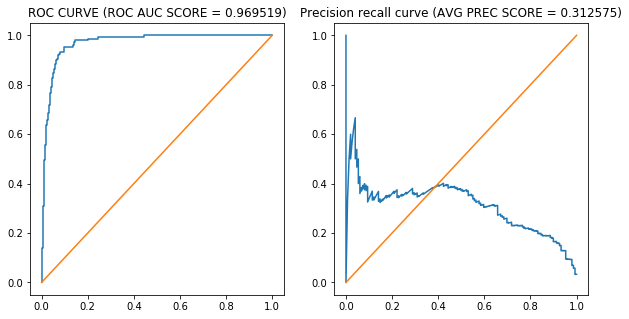

In [13]:
balds = entropy_of_mean - mean_of_entropies

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

tpr, fpr, thresholds = roc_curve(1 - correctly_classified, balds)
plt.plot(tpr, fpr)
plt.plot([0, 1], [0, 1])
plt.title('ROC CURVE (ROC AUC SCORE = %f)' % roc_auc_score(1 - correctly_classified, balds))

plt.subplot(1, 2, 2)

prec, rec, thresholds = precision_recall_curve(1 - correctly_classified, balds)
plt.plot(rec, prec)
plt.plot([0, 1], [0, 1])
_ = plt.title('Precision recall curve (AVG PREC SCORE = %f)' % average_precision_score(1 - correctly_classified, balds))
